In [4]:
import numpy as np
import matplotlib .pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler #scale data b/w 0 to 1
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


In [5]:
crypto_currency = 'BTC-USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

# Fetching data using yfinance
data = yf.download(crypto_currency, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


### Preparing Data

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [8]:
## Choosing the number of days we want out predcitions to be based on
prediction_days = 60

x_train, Y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0]) # starting from x - prediciton_days to x days
    Y_train.append(scaled_data[x, 0]) # Day after that period

x_train, Y_train = np.array(x_train), np.array(Y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Creating a neural network

In [14]:
model = Sequential()

## LSTM: long short term layers
model.add(LSTM(units=50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, Y_train, epochs=25, batch_size=32)

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0160
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0027
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0023
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0025
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0021
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0018
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0019
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0018
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0016
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0016
Epoch 11/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015
Epoch 12/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0017
Epoch 13/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0014
Epoch 14/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0015
Epoch 15/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0014
Epoc

### Testing the Model

In [15]:
test_start = dt.datetime(2024,1,1)
test_end = dt.datetime.now()

test_data = yf.download(crypto_currency, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# go back -test_data, from there go back -60 days. Then predict and compare them with actual values
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)


[*********************100%%**********************]  1 of 1 completed


C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [21]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


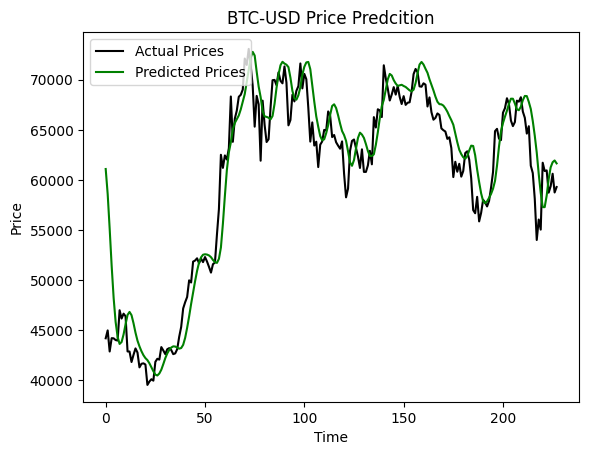

In [22]:
plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
plt.plot(prediction_prices, color = 'green', label = 'Predicted Prices')
plt.title(f'{crypto_currency} Price Predcition')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.show()

### Predict Nexr Day

In [26]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))


prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[[61169.32]]


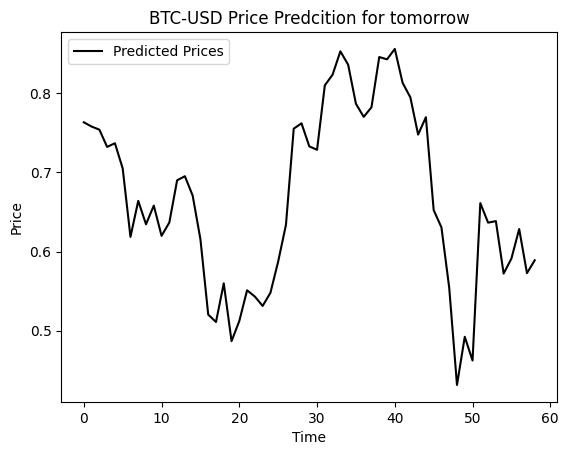

In [29]:
real_data_flattened = real_data.flatten()
plt.plot(real_data_flattened, color='black', label='Predicted Prices')
plt.title(f'{crypto_currency} Price Predcition for tomorrow')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.show()